In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

# Some hyper-param
input_shape = [224, 224, 3]
batch_size = 128
num_epochs = 10
random_seed = 42

# **Preparing the Data**

In [2]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Num of classes
num_classes = cifar_info.features['label'].num_classes

# Num of train/val imgs
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

# Train/val steps per epoch
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteGBIGEG/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteGBIGEG/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000

In [3]:
train_cifar_dataset = cifar_utils.get_dataset('train', batch_size=batch_size,
                                              num_epochs=num_epochs, shuffle=True,
                                              input_shape=input_shape, 
                                              return_batch_as_tuple=True,
                                              seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset('val', batch_size=batch_size,
                                            num_epochs=num_epochs, shuffle=False,
                                            input_shape=input_shape,
                                            return_batch_as_tuple=True,
                                            seed=random_seed)

# **Freezing the ResNet Feature Extractor**

## **Building a new classifier from pre-trained Keras applications**

Download feature extractor

In [4]:
resnet50_feature_extractor = tf.keras.applications.resnet50.ResNet50(
                                include_top=False, weights='imagenet',
                                input_shape=input_shape)

94781440/94765736 [==============================] - 1s 0us/step


While we want to preserve feature-extracting layers, **we should be careful not to freeze some other layers like the regularization ones**. Layers like the *batch-norm* have some trainable parameters which tend to become too data-spectific. It is often recommended not to freeze such layers and let them adapt to the new task/dataset. Therefore, we check the layer's type before freezing them or not:

In [5]:
frozen_layers, trainable_layers = [], []
for layer in resnet50_feature_extractor.layers:
  if isinstance(layer, tf.keras.layers.Conv2D):
    layer.trainable = False
    frozen_layers.append(layer.name)
  elif len(layer.weights) > 0:
    trainable_layers.append(layer.name) 

In [6]:
log_begin_red, log_begin_bold, log_end_format = '\033[91m', '\033[1m', '\033[0m'

print('{0}Layer we froze:{1} {2} {3}(total = {4}){1}'.format(log_begin_red,
                                                             log_end_format,
                                                             frozen_layers,
                                                             log_begin_bold,
                                                             len(frozen_layers)))

print('\n{0}Layer which will be fine-tuned:{1} '\
      '{2} {3}(total = {4}){1}'.format(log_begin_red, log_end_format, 
                                       trainable_layers, log_begin_bold,
                                       len(trainable_layers)))

Layer we froze: ['conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block2_1_conv', 'conv2_block2_2_conv', 'conv2_block2_3_conv', 'conv2_block3_1_conv', 'conv2_block3_2_conv', 'conv2_block3_3_conv', 'conv3_block1_1_conv', 'conv3_block1_2_conv', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block2_1_conv', 'conv3_block2_2_conv', 'conv3_block2_3_conv', 'conv3_block3_1_conv', 'conv3_block3_2_conv', 'conv3_block3_3_conv', 'conv3_block4_1_conv', 'conv3_block4_2_conv', 'conv3_block4_3_conv', 'conv4_block1_1_conv', 'conv4_block1_2_conv', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block2_1_conv', 'conv4_block2_2_conv', 'conv4_block2_3_conv', 'conv4_block3_1_conv', 'conv4_block3_2_conv', 'conv4_block3_3_conv', 'conv4_block4_1_conv', 'conv4_block4_2_conv', 'conv4_block4_3_conv', 'conv4_block5_1_conv', 'conv4_block5_2_conv', 'conv4_block5_3_conv', 'conv4_block6_1_conv', 'conv4_block6_2_conv', 'conv4_block6_3_conv', 'co

Add on top of this network the trainable layers to make predictions from the features

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

avg_pool = GlobalAveragePooling2D()(resnet50_feature_extractor.output)
prediction = Dense(num_classes, activation='softmax')(avg_pool)
resnet50_freeze = Model(resnet50_feature_extractor.input, prediction)

## **Training the network**

In [8]:
from keras_custom_callbacks import SimpleLogCallback
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

metrics_to_print = {'loss': 'loss', 'v-loss': 'val_loss',
                    'acc': 'acc', 'v-acc': 'val_acc', 
                    'top5-acc': 'top5_acc', 'v-top5-acc': 'val_top5_acc'}

metrics = [SparseCategoricalAccuracy(name='acc'), 
           SparseTopKCategoricalAccuracy(name='top5_acc')]

callbacks = [EarlyStopping(patience=8), 
             SimpleLogCallback(metrics_to_print, num_epochs, 1)]

resnet50_freeze.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(),
                        metrics=metrics)

history = resnet50_freeze.fit(train_cifar_dataset, epochs=num_epochs,
                              steps_per_epoch=train_steps_per_epoch, callbacks=callbacks,
                              validation_data=val_cifar_dataset, verbose=0,
                              validation_steps=val_steps_per_epoch)

Training: start
Epoch  0/10: loss = 2.0661; v-loss = 6.7247; acc = 0.4652; v-acc = 0.0117; top5-acc = 0.7501; v-top5-acc = 0.0432
Epoch  1/10: loss = 1.1605; v-loss = 3.3249; acc = 0.6653; v-acc = 0.3109; top5-acc = 0.9099; v-top5-acc = 0.5801
Epoch  2/10: loss = 0.9484; v-loss = 1.0095; acc = 0.7199; v-acc = 0.7118; top5-acc = 0.9370; v-top5-acc = 0.9318
Epoch  3/10: loss = 0.8266; v-loss = 0.8783; acc = 0.7524; v-acc = 0.7398; top5-acc = 0.9504; v-top5-acc = 0.9457
Epoch  4/10: loss = 0.7447; v-loss = 0.8932; acc = 0.7729; v-acc = 0.7379; top5-acc = 0.9594; v-top5-acc = 0.9444
Epoch  5/10: loss = 0.6692; v-loss = 0.8662; acc = 0.7967; v-acc = 0.7497; top5-acc = 0.9651; v-top5-acc = 0.9485
Epoch  6/10: loss = 0.6125; v-loss = 0.8525; acc = 0.8105; v-acc = 0.7548; top5-acc = 0.9714; v-top5-acc = 0.9494
Epoch  7/10: loss = 0.5751; v-loss = 0.8317; acc = 0.8218; v-acc = 0.7631; top5-acc = 0.9747; v-top5-acc = 0.9529
Epoch  8/10: loss = 0.5314; v-loss = 0.8546; acc = 0.8338; v-acc = 0.757

Epoch  9/10: loss = 0.5040; v-loss = 0.8356; acc = 0.8406; v-acc = 0.7631; top5-acc = 0.9802; v-top5-acc = 0.9531
Training: end


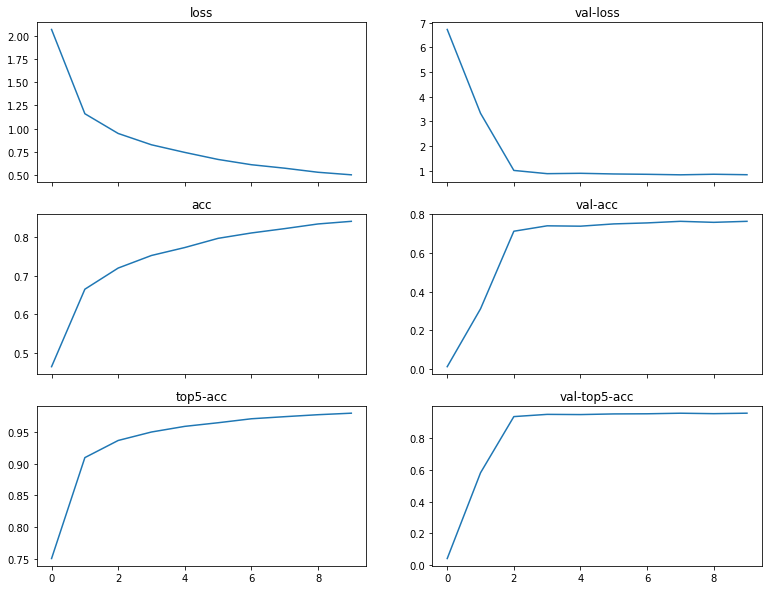

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(13, 10), sharex='col')
axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('acc')
axs[1, 1].set_title('val-acc')
axs[2, 0].set_title('top5-acc')
axs[2, 1].set_title('val-top5-acc')

axs[0, 0].plot(history.history['loss'])
axs[0, 1].plot(history.history['val_loss'])
axs[1, 0].plot(history.history['acc'])
axs[1, 1].plot(history.history['val_acc'])
axs[2, 0].plot(history.history['top5_acc'])
axs[2, 1].plot(history.history['val_top5_acc'])